In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as sfft

In [2]:
eftem_stack = np.load('data/data_cube.npy')
single_frame = eftem_stack[25]
#eftem_stack = None

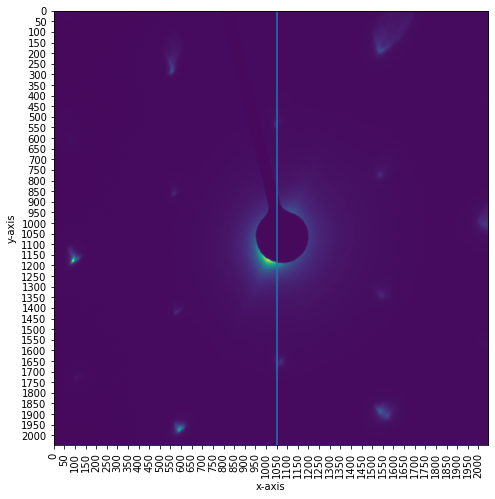

In [3]:
plt.imshow(single_frame)
plt.gcf().set_size_inches(8,8)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.xticks([i for i in range(0,2050,50)], rotation=90)
plt.yticks([i for i in range(0,2050,50)])
plt.axvline(1050)

So our goal is now to find the centres of the \[100\] and \[-100\] bright spots.

In [4]:
def get_true_centres(frame, false_centers, leeway=100):
    true_centers = np.array([], dtype=object)
    for i in false_centers:
        false_center = i
        print(i)
        part_frame = frame[i[0]-leeway:i[0]+leeway, i[1]-leeway:i[1]+leeway]
        [part_true_y, part_true_x] = np.argwhere(part_frame==part_frame.max() )[0]
        [true_y, true_x] = [part_true_y+(i[0]-leeway), part_true_x+(i[1]-leeway)]
        true_centers = np.append(true_centers, (true_y, true_x))
    return true_centers

In [5]:
false_centers = np.array([[1650,1050],[540,1150]])
true_centers = get_true_centres(single_frame, false_centers)

[1650 1050]
[ 540 1150]


In [6]:
print(true_centers)

[1658 1067 532 1050]


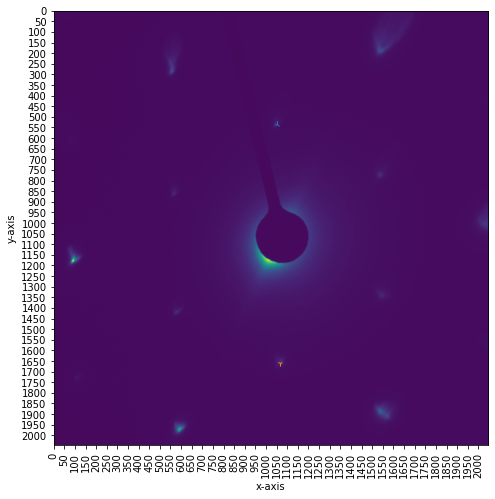

In [7]:


plt.imshow(single_frame)
plt.gcf().set_size_inches(8,8)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.xticks([i for i in range(0,2050,50)], rotation=90)
plt.yticks([i for i in range(0,2050,50)])
plt.plot(1050,532, marker='2')
plt.plot(1067,1658, marker='1')
plt.savefig("figures/true_centers.png")

In [8]:
point_100 = (1050,532)
point_a100 = (1067,1658)

total_distance = np.sqrt( np.abs(point_100[0]-point_a100[0])**2 + np.abs(point_100[1]-point_a100[1])**2 ) #in px

#This total distance should be equal to two \times the magnitude of the b1 reciprocal lattice vector

In [9]:
angstrom = 1
lattice_constant = 3.153*angstrom
b1_magn = 2*np.pi /lattice_constant /np.sqrt(3)

In [10]:
print(total_distance) #px

1126.1283230609201


In [11]:
scale = 2*b1_magn/total_distance #[A^-1] per px
print(scale) #in 1/angstrom

0.002043324698073994


In [12]:
x = y = np.around( (np.arange(2048)-1024)*scale, 3)
ticks = [i for i in range(0,2050,50)]
labels = [x[i] for i in range(0,2050,50)]
print(labels)

[-2.092, -1.99, -1.888, -1.786, -1.684, -1.582, -1.479, -1.377, -1.275, -1.173, -1.071, -0.969, -0.866, -0.764, -0.662, -0.56, -0.458, -0.356, -0.253, -0.151, -0.049, 0.053, 0.155, 0.257, 0.36, 0.462, 0.564, 0.666, 0.768, 0.87, 0.973, 1.075, 1.177, 1.279, 1.381, 1.483, 1.586, 1.688, 1.79, 1.892, 1.994]


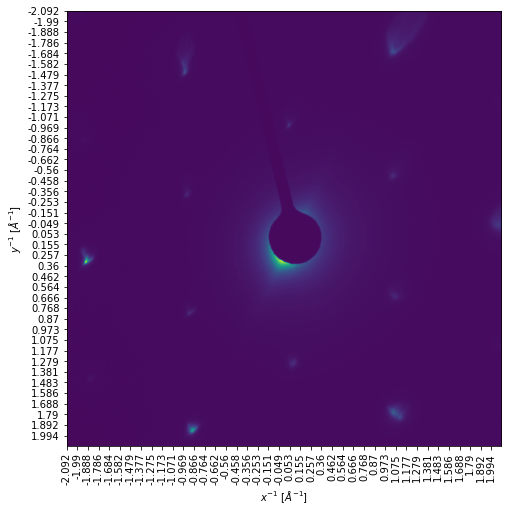

In [13]:
a = plt.subplot(1,1,1)
plt.imshow(single_frame)
plt.gcf().set_size_inches(8,8)
a.set_xlabel(r'$x^{-1}$ [$\AA^{-1}$]')
a.set_ylabel(r'$y^{-1}$ [$\AA^{-1}$]')
a.set_xticks( ticks )
a.set_xticklabels( labels, rotation=90)
a.set_yticks( ticks )
a.set_yticklabels( labels )
plt.savefig("figures/proper_axes.png")


In [14]:
#Some system parameters all in SI
planck_constant = 6.626e-34
electron_mass = 9.109e-31
elementary_charge = 1.602e-19
speed_limit = 299792458
camera_distance = 0.8           #ImageList.2.ImageTags.Microscope Info.STEM Camera Length
ccd_dimensions = (2048, 2048)   #ImageList.2.ImageTags.Acquisition.Device.Active Size (pixels)
ccd_pixel_size = 18e-6          #ImageList.2.ImageTags.Acquisition.Device.CCD.Pixel Size
electron_voltage = 200e3        #ImageList.2.ImageTags.Microscope Info.Formatted Voltage'
                                #ImageList.2.ImageTags.Microscope Info.Voltage
camera_sample_dist = 0.8        #ImageList.2.ImageTags.Microscope Info.STEM Camera Length

incident_beam_energy = electron_voltage

electron_wave_lambda = planck_constant * speed_limit / np.sqrt( (elementary_charge * electron_voltage)**2
                        +2*elementary_charge*electron_voltage*electron_mass*speed_limit**2)

electron_wave_k = 2*np.pi / electron_wave_lambda


In [15]:
def char_el_angle(dE, E0):
    return dE /2 /E0

(1058.5, 1095.0)


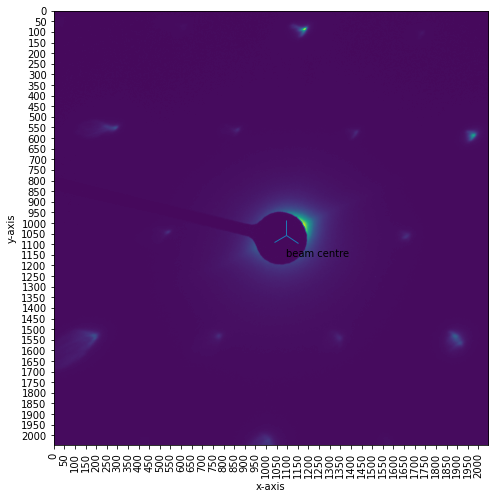

In [16]:
#centre of image is taken to be right in the middle of the previously determined [100] and [-100] spot
#point_100 = (1050,532)
#point_a100 = (1067,1658)
beam_centre = (1050+(1067-1050)/2 , 532+(1658-532)/2) #The pixel we assume the electron beam goes through
print(beam_centre)

plt.imshow(single_frame.T)
plt.gcf().set_size_inches(8,8)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.xticks([i for i in range(0,2050,50)], rotation=90)
plt.yticks([i for i in range(0,2050,50)])
plt.plot(beam_centre[1], beam_centre[0], marker='2', markersize=30)
plt.text(beam_centre[1], beam_centre[0]+100, "beam centre")
plt.savefig("figures/true_centers.png")


In [17]:
# Creating an array of size (2101,2101) with zero in the middle
x = ( np.arange(2048)-(1024+(beam_centre[1]-1024)) )*ccd_pixel_size
y = ( np.arange(2048)-(1024+(beam_centre[0]-1024)) )*ccd_pixel_size

Y, X = np.meshgrid(y, x)
R = np.sqrt( X**2 + Y**2 )
theta_map = R /2 /camera_distance
# We now want to map these values of theta to the correspond pixels, so we roll the center of theta_map to beam_centre

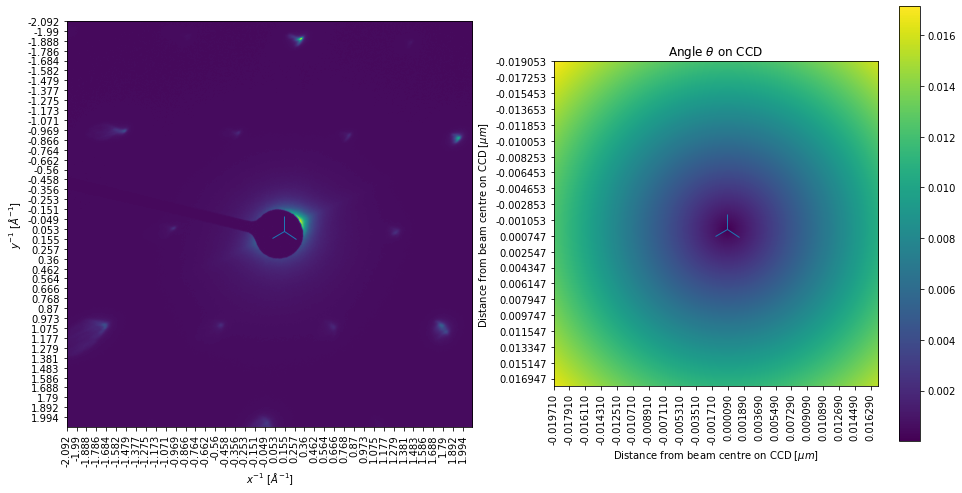

In [18]:
theta_ticks_x = [np.arange(2048)[i] for i in range(0,2045,100)]
theta_ticks_y = [np.arange(2048)[i] for i in range(0,2045,100)]
theta_ticks_x_labels = ["{0:2f}".format(x[i]) for i in range(0,2045,100)]
theta_ticks_y_labels = ["{0:2f}".format(y[i]) for i in range(0,2045,100)]

fig, ax = plt.subplots(1,2)
plt.gcf().set_size_inches(16,8)
ax[0].imshow(single_frame.T)
ax[0].set_xlabel(r'$x^{-1}$ [$\AA^{-1}$]')
ax[0].set_ylabel(r'$y^{-1}$ [$\AA^{-1}$]')
ax[0].set_xticks( ticks )
ax[0].set_xticklabels( labels, rotation=90)
ax[0].set_yticks( ticks )
ax[0].set_yticklabels( labels )
ax[0].plot(beam_centre[1] ,beam_centre[0], marker='2', markersize=30)
img = ax[1].imshow(theta_map.T)
ax[1].plot(beam_centre[1] ,beam_centre[0], marker='2', markersize=30)
ax[1].set_xticks( theta_ticks_x )
ax[1].set_xticklabels( theta_ticks_x_labels, rotation=90)
ax[1].set_yticks( theta_ticks_y )
ax[1].set_yticklabels( theta_ticks_y_labels )
ax[1].set_xlabel(r"Distance from beam centre on CCD [$\mu m$]")
ax[1].set_ylabel(r"Distance from beam centre on CCD [$\mu m$]")
ax[1].set_title(r"Angle $\theta$ on CCD")
fig.colorbar(img)

In [19]:
print(len(theta_ticks_x_labels))

21


In [20]:
momentum_transfer_par = char_el_angle(0.5*elementary_charge, incident_beam_energy)*electron_wave_k
momentum_transfer_per = theta_map*electron_wave_k

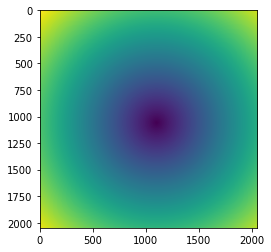

In [21]:
plt.imshow(np.sqrt(momentum_transfer_par**2 + momentum_transfer_per**2).T) #q

## Radial Integration for q-EELS map
Map of intensity for energy and momentum

1. A (corrected) stack is loaded
2. The centre of the ZLP is defined
3. We define a momentum transfer map


In [22]:
def get_true_centres(frame, false_centers, leeway=100):
    true_centers = np.array([], dtype=object)
    for i in false_centers:
        false_center = i
        part_frame = frame[i[0]-leeway:i[0]+leeway, i[1]-leeway:i[1]+leeway]
        [part_true_y, part_true_x] = np.argwhere(part_frame==part_frame.max() )[0]
        [true_y, true_x] = [part_true_y+(i[0]-leeway), part_true_x+(i[1]-leeway)]
        true_centers = np.append(true_centers, (true_y, true_x))
    return true_centers

def get_beam_centre(peak, antipeak):
    if peak[0] > antipeak[0]:
        zlp_x = antipeak[0]+(peak[0]-antipeak[0])/2
    else:
        zlp_x = peak[0]+(antipeak[0]-peak[0])/2
    if peak[1] > antipeak[1]:
        zlp_y = antipeak[1]+(peak[1]-antipeak[1])/2
    else:
        zlp_y = peak[1]+(antipeak[1]-peak[1])/2
    return (zlp_y, zlp_x)

def generate_angle_map(slice_dimensions, beam_centre):
    map_size_x = ( np.arange(slice_dimensions[1]) -int(slice_dimensions[1]/2) +beam_centre[1])*ccd_pixel_size
    map_size_y = ( np.arange(slice_dimensions[0]) -int(slice_dimensions[0]/2) +beam_centre[0])*ccd_pixel_size
    map_x, map_y = np.meshgrid(map_size_y, map_size_x)
    radius_map = np.sqrt(map_x**2 + map_y**2)
    theta_map = radius_map /2 /camera_distance
    return theta_map

def char_el_angle(dE, E0):
    return dE /2 /E0 

def momentum_trans_map(theta_map):
    momentum_transfer_par = char_el_angle(0.5*elementary_charge, incident_beam_energy)*electron_wave_k
    momentum_transfer_per = theta_map*electron_wave_k
    return np.sqrt(momentum_transfer_par**2 + momentum_transfer_per**2)

In [64]:
def radial_integration(slice, slice_centre, r1, r2, ringsize):
    offset_x = slice_centre[1]-slice.shape[1]/2
    offset_y = slice_centre[0]-slice.shape[0]/2
    x = np.linspace(-int(slice.shape[1]/2)-offset_x, int(slice.shape[1]/2)+offset_x, slice.shape[1])
    y = np.linspace(-int(slice.shape[0]/2)-offset_y, int(slice.shape[0]/2)+offset_y, slice.shape[0])
    Y, X = np.meshgrid(y, x)
    radii = np.sqrt( (X-offset_x)**2 + (Y-offset_y)**2 )

    integration_area = np.where(radii < r2, np.where( (r2 - ringsize ) < radii, slice, 0), 0 )
    integral = np.sum(integration_area)
    return(integral)

In [66]:
def radial_integration_stack(stack, stack_centre, r0, r1, ringsize):
    offset_x = stack_centre[1]-stack.shape[1]/2
    offset_y = stack_centre[0]-stack.shape[0]/2
    x = np.linspace(-int(stack.shape[2]/2)-offset_x, int(stack.shape[2]/2)+offset_x, stack.shape[2])
    y = np.linspace(-int(stack.shape[1]/2)-offset_y, int(stack.shape[1]/2)+offset_y, stack.shape[1])
    Y, X = np.meshgrid(y, x)
    radii = np.sqrt( (X-offset_x)**2 + (Y-offset_y)**2 )
    radii3d = np.broadcast_to(radii, stack.shape)

    integration_area = np.where( (radii3d>(r1-ringsize)) & (radii3d<r1), stack, 0)
    integral = np.sum( np.sum(integration_area, axis=2), axis=1)
    return(integral)

In [25]:
from tqdm import tqdm

In [69]:
"""
So in this function should give a plot of the intensity per momentum and per energy.
"""
def get_qeels_map(stack, r0, r1, peak, anti_peak, stepsize = 1, preferred_frame=0, ringsize=5):
    false_peaks = [peak, anti_peak]
    (esize, xsize, ysize) = stack.shape
    iterate = range( r0, r1, stepsize)
    momentum_axis = np.array([])
    intensity_map = np.zeros((len(iterate), esize))

    true_peak_centres = get_true_centres(stack[preferred_frame], false_peaks)
    true_centre_peak = [true_peak_centres[0], true_peak_centres[1]]
    true_centre_anti_peak = [true_peak_centres[2], true_peak_centres[3]]   
    beam_centre = get_beam_centre(true_centre_peak, true_centre_anti_peak)

    theta_map = generate_angle_map(stack[0].shape, beam_centre)
    momentum_map = momentum_trans_map(theta_map)
    index = 0
    for i in tqdm(iterate):
        momentum_frame_total = radial_integration(stack[preferred_frame], beam_centre, r0, i, ringsize)
        momentum_axis = np.append(momentum_axis, momentum_frame_total)
    for j in tqdm(iterate):
        intensity = radial_integration_stack(stack, beam_centre, r0, j, ringsize)
        intensity_map[index,:] = intensity
        index += 1

    return intensity_map, momentum_axis

In [78]:
false_peak = [ 540, 1150]
false_anti_peak = [1650, 1050]
qeels_map, momentum_ax = get_qeels_map(eftem_stack, 0, 1000, false_peak, false_anti_peak, preferred_frame=1, stepsize=1)

100%|██████████| 1000/1000 [26:25<00:00,  1.59s/it]


In [79]:
np.save("data/qeels_raw_ultra_high_res", qeels_map)
np.save("data/momentum_ultra_high_res", momentum_ax)


In [30]:
qeels_map = np.load("data/qeels_raw.npy")
momentum_ax = np.load("data/momentum.npy")

In [84]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250

(1000,)


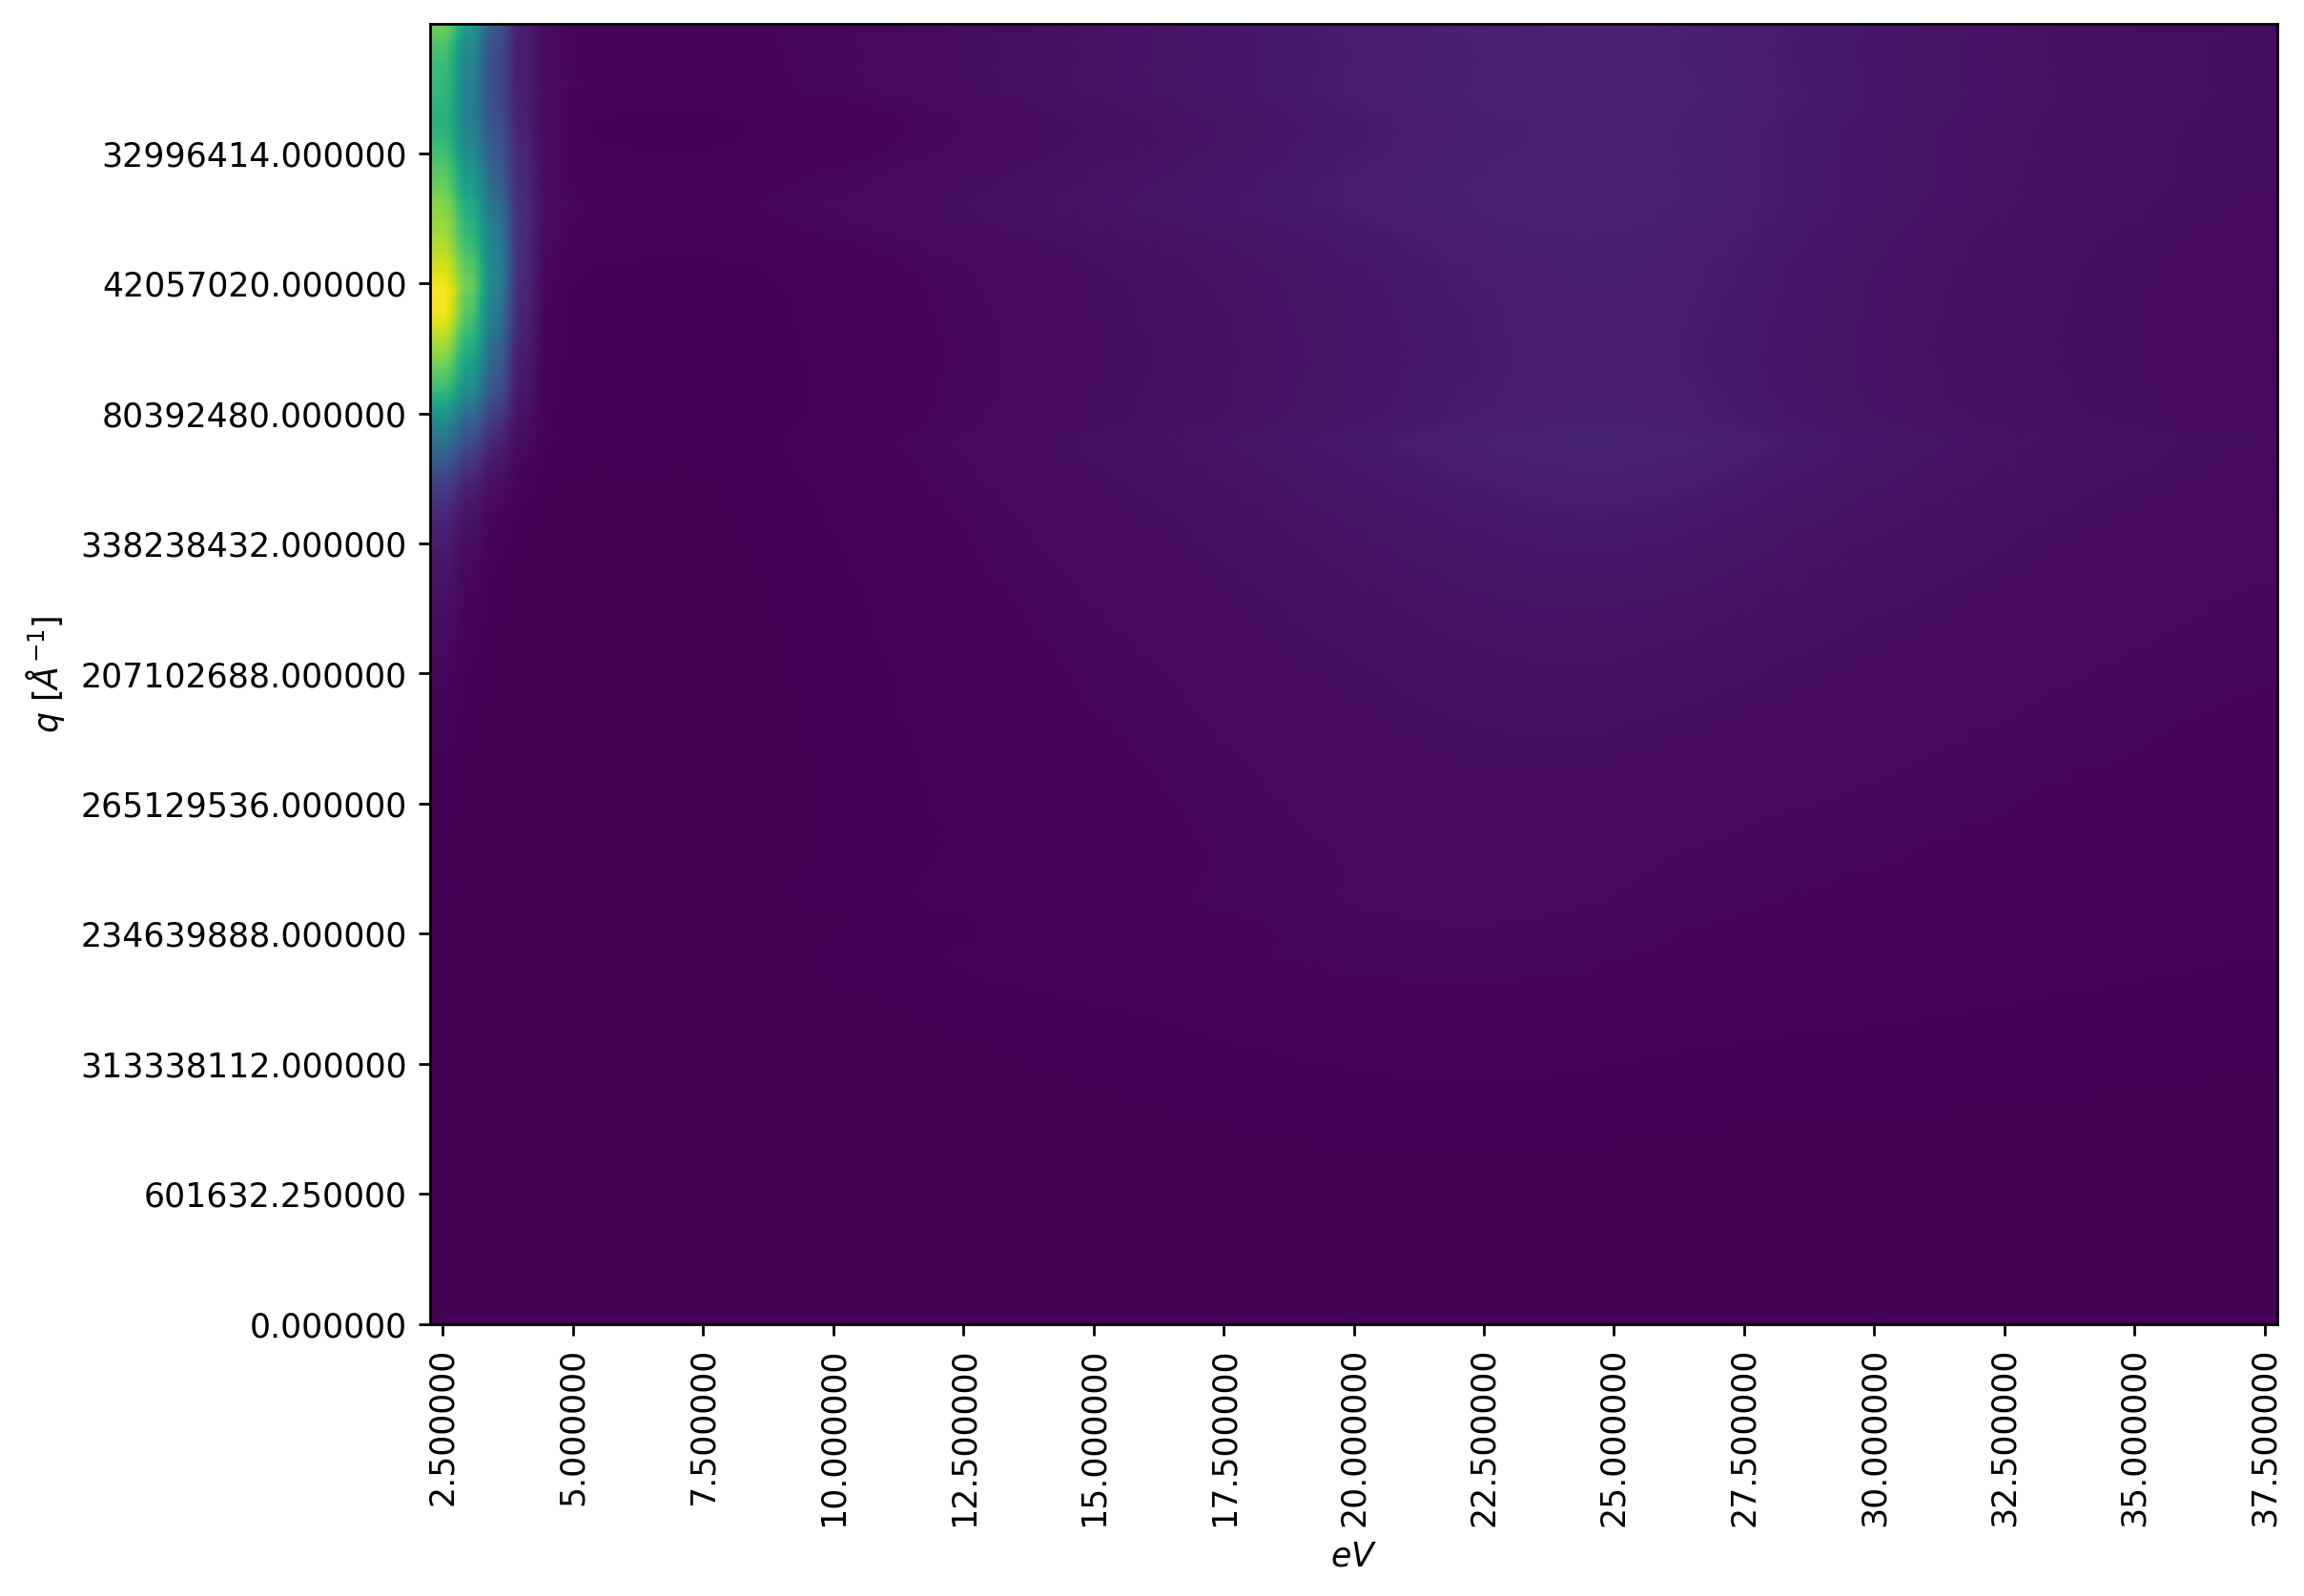

In [100]:

energies = np.linspace(2.5,37.5,71)

print(momentum_ax.shape)


energies = np.append(energies, energies[1]-energies[0])

fig, ax = plt.subplots(1,1)
plt.gcf().set_size_inches(10,8)
ax.imshow(qeels_map, origin='lower', aspect=0.05)
ax.set_xlabel(r'$eV$')
ax.set_ylabel(r'$q$ [$\AA^{-1}$]')
ax.set_xticks( [i for i in range(0,71,5)] )
ax.set_xticklabels( ["{0:1f}".format(energies[i]) for i in range(0,71,5)], rotation=90)
ax.set_yticks( [i for i in range(0,len(momentum_ax),100)] )
ax.set_yticklabels( ["{0:1f}".format(momentum_ax[i]) for i in range(0,len(momentum_ax),100)] )

plt.savefig("qeels_uh.png")

In [87]:
def sigmoid(x):
    a = np.average(x)
    b = np.std(x)
    return 1/(1+np.exp(-(x-a)/b))

In [88]:
processed_qeels = sigmoid(qeels_map[:,4:])

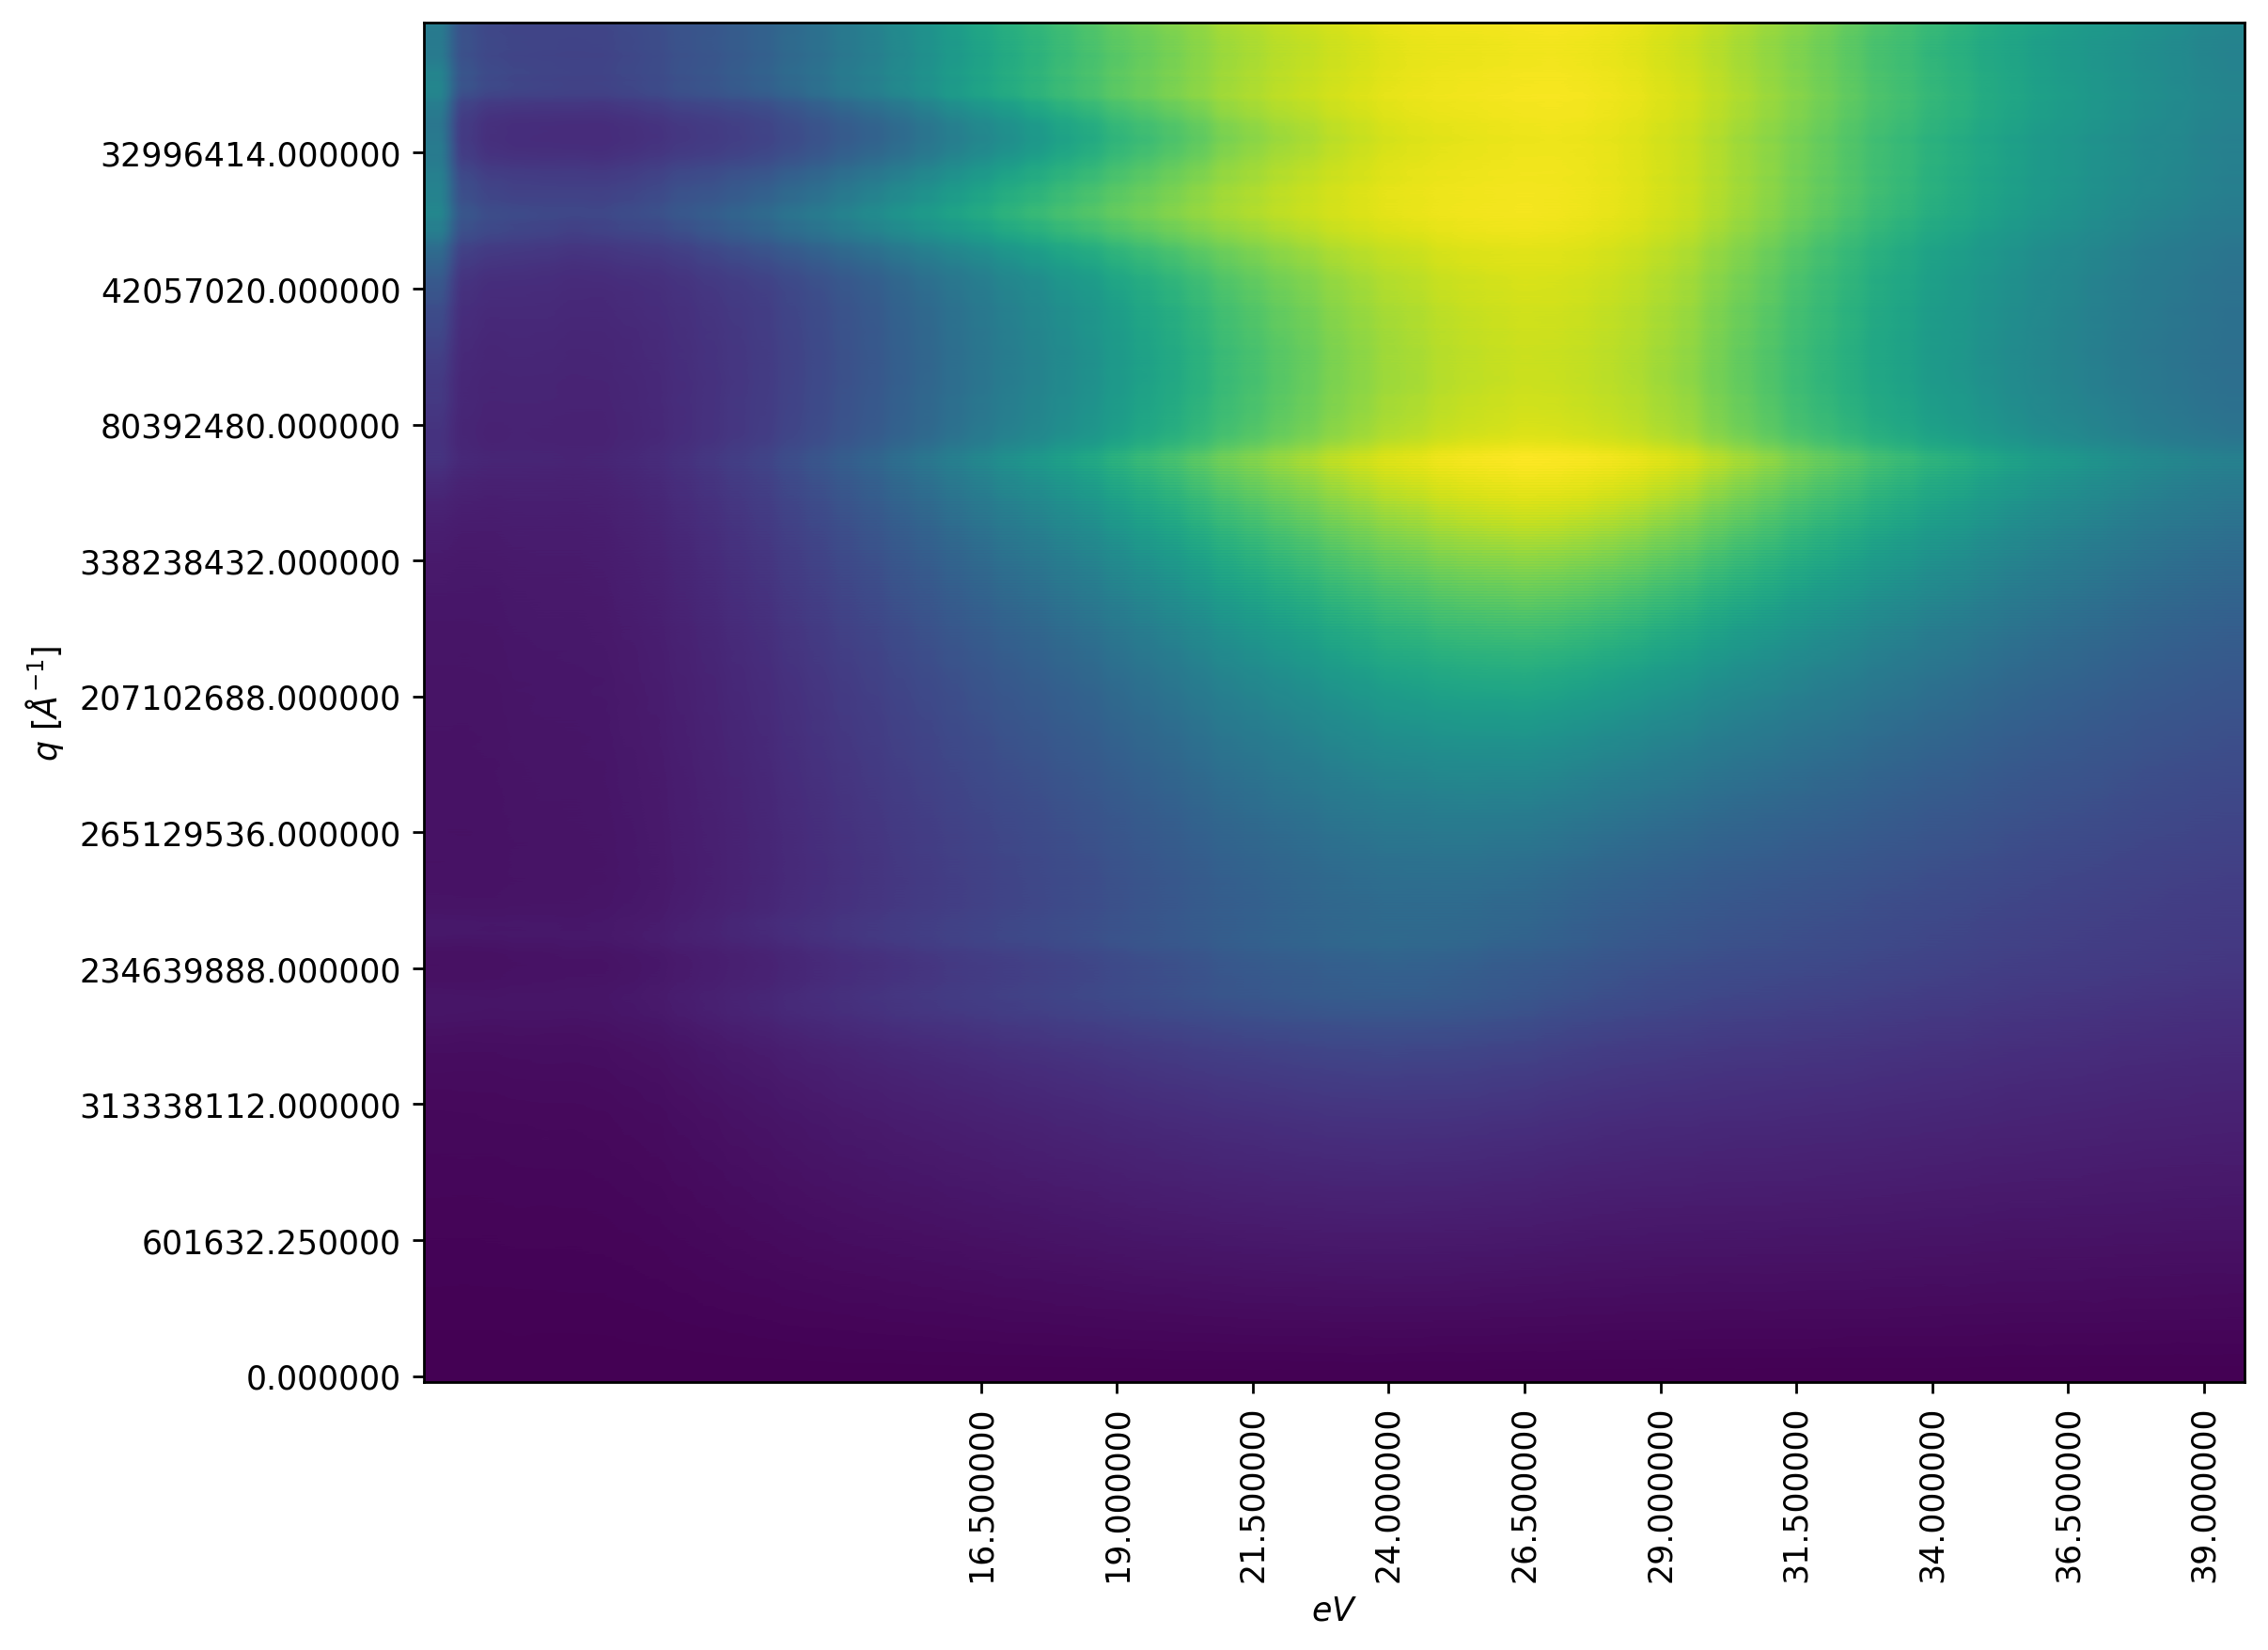

In [99]:

fig, ax = plt.subplots(1,1)
plt.gcf().set_size_inches(10,8)
ax.imshow(processed_qeels, origin='lower', aspect=0.05)
ax.set_xlabel(r'$eV$')
ax.set_ylabel(r'$q$ [$\AA^{-1}$]')
ax.set_xticks( [i for i in range(0,71-4,5)][4:] )
ax.set_xticklabels( ["{0:1f}".format(energies[i]+4) for i in range(0,71-4,5)][4:], rotation=90)
ax.set_yticks( [i for i in range(4,len(momentum_ax),100)] )
ax.set_yticklabels( ["{0:1f}".format(momentum_ax[i]) for i in range(0,len(momentum_ax),100)] )

plt.savefig("qeels_uh_processed.png")